In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import (
    avg_pool2d,
    dropout,
    dropout2d,
    interpolate,
    max_pool2d,
    relu,
    sigmoid,
    tanh,
)
from torch.nn import (
    Module, Parameter, init,
    Conv2d, ConvTranspose2d, Linear, LSTM, GRU,
    BatchNorm1d, BatchNorm2d,
    PReLU
)


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [3]:

def fft_transform(data):
    fft_data = []
    for img, _ in data:
        fft = np.fft.fft2(img.numpy().squeeze())
        fft_data.append(fft)
    return np.array(fft_data)

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

class ComplexDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        real_data = torch.from_numpy(sample.real).float()
        imag_data = torch.from_numpy(sample.imag).float()
        complex_data = torch.stack((real_data, imag_data), dim=0)

        if self.transform:
            complex_data = self.transform(complex_data)

        return complex_data, label


class RandomPixelMask(object):
    """
     A augmentation technique to set datapoints in a 2D matrix to 0. It sets a fraction between 0 and max_fraction to 0. Intended to work in the frequency domain
    """

    def __init__(self, max_fraction=0.25):
        self.max_fraction = max_fraction

    def __call__(self, sample):
        # Assuming sample is a 2-channel tensor of shape (2, 28, 28)
        fraction = random.uniform(0, self.max_fraction)
        mask = torch.rand(1, 28, 28) < fraction
        mask = mask.repeat(2, 1, 1)  # Repeat the mask for both channels
        sample[mask] = 0.0
        return sample

transform = transforms.Compose([RandomPixelMask()])
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, transform=None) 

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


## Testing parameters of the inverse Fourier Transform

In [49]:
def idft2d(F,alpha=1, beta=1, gamma=1, delta=1):
    F = torch.complex(F[0], F[1])
    M, N = F.shape
    f = np.zeros((M, N), dtype=np.complex64)
    
    for x in range(M):
        for y in range(N):
            sum_val = 0
            for u in range(M):
                for v in range(N):
                    sum_val += beta*F[u, v] * np.exp(1j * 2 * np.pi * ((gamma*u * x / M) + (delta*v * y / N)))
            f[x, y] = sum_val / alpha*((M * N))
    
    return f


### Test alpha

614.6572 2.9907228e-06 tensor(784.0002) tensor(5.0307e-16)


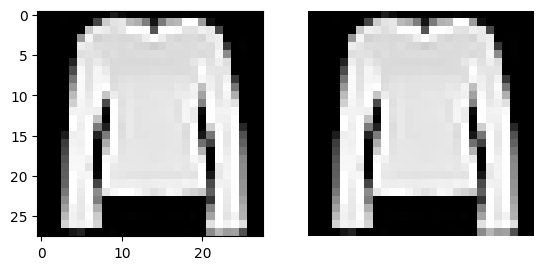

In [73]:
# Get the first example from the train_loader
number =31
example_data, _ = next(iter(train_loader))
example_complex = example_data[number]
# Apply the inverse Fourier transform with default parameters
reconstructed_image = idft2d(example_data[number], alpha =1000)
complex_n = torch.complex(example_complex[1], example_complex[0])
reconstructed_image_fft = torch.fft.fft2(complex_n)
print(np.abs(reconstructed_image).max(),np.abs(reconstructed_image).min(), np.abs(reconstructed_image_fft).max(), np.abs(reconstructed_image_fft).min())
# Display the reconstructed image
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap='gray')
plt.axis('off')
plt.show()

Alpha changes the maximum of our range, basically the "energy" in the image

### Test Beta

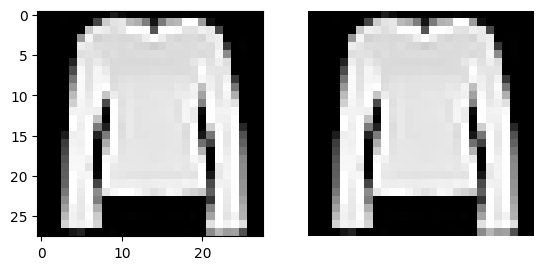

6146.5684 2.336502e-05 tensor(784.0002) tensor(5.0307e-16)


In [74]:
reconstructed_image = idft2d(example_data[number], alpha =1, beta = 1/100)
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap='gray')
plt.axis('off')
plt.show()
print(np.abs(reconstructed_image).max(),np.abs(reconstructed_image).min(), np.abs(reconstructed_image_fft).max(), np.abs(reconstructed_image_fft).min())

### Test Gamma and Delta

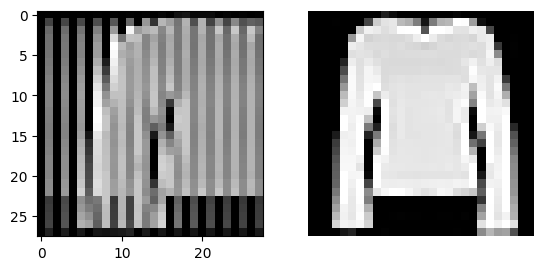

789490.4 0.0029907227 tensor(784.0002) tensor(5.0307e-16)


In [75]:
reconstructed_image = idft2d(example_data[number], alpha =1, beta = 1, gamma=1, delta=0.5)
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap='gray')
plt.axis('off')
plt.show()
print(np.abs(reconstructed_image).max(),np.abs(reconstructed_image).min(), np.abs(reconstructed_image_fft).max(), np.abs(reconstructed_image_fft).min())

## Show filter in frequency domain

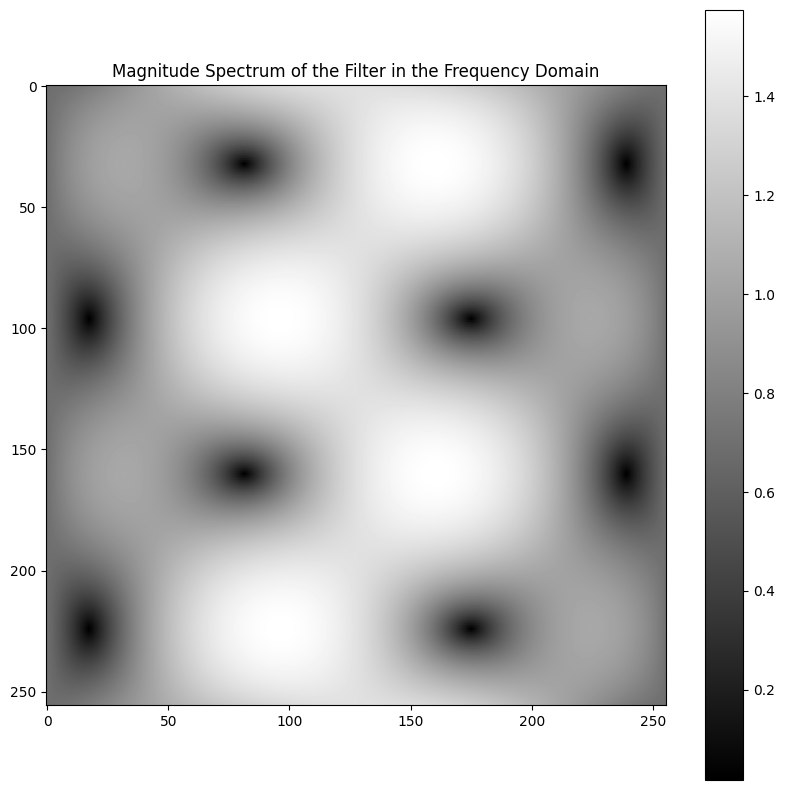

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Define the filter
filter_3x3 = np.array([[-1, 0, 1], [0, 0, 0], [1, 1, 1]])

# Pad the filter to match the image size (256x256)
filter_padded = np.zeros((256, 256))
filter_padded[:3, :3] = filter_3x3

# Compute the Fourier transform of the padded filter
filter_fft = np.fft.fft2(filter_padded)

# Shift the zero-frequency component to the center of the spectrum
filter_fft_shifted = np.fft.fftshift(filter_fft)

# Get the magnitude spectrum for visualization
magnitude_spectrum = np.log(np.abs(filter_fft_shifted) + 1)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the Filter in the Frequency Domain')
plt.colorbar()
plt.show()

### Vertical Filter

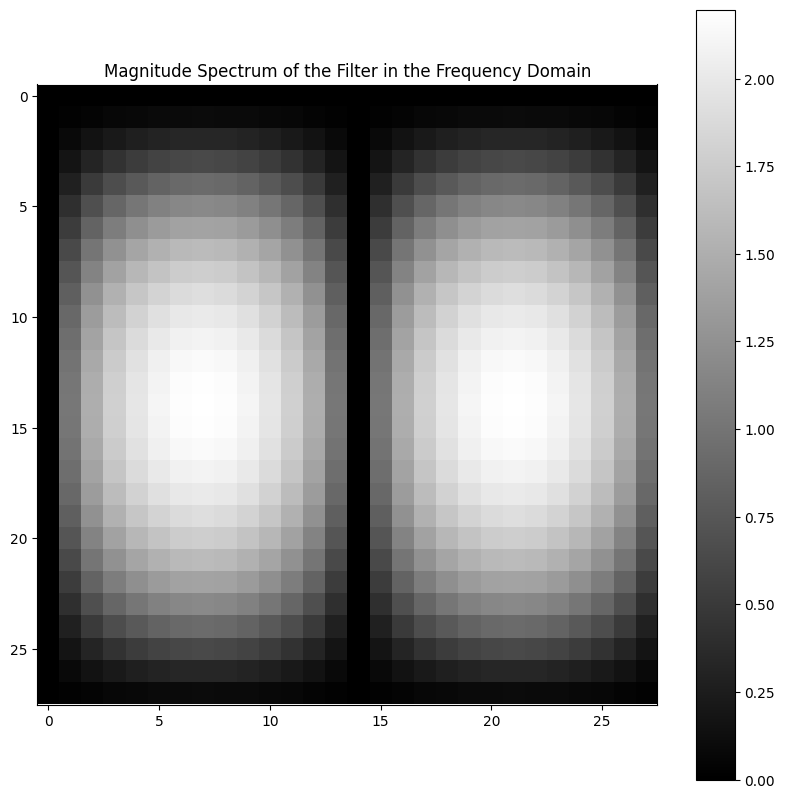

In [78]:
sobel_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Pad the filter to match the image size (256x256)
filter_padded = np.zeros((28, 28))
filter_padded[:3, :3] = sobel_vertical

# Compute the Fourier transform of the padded filter
filter_fft = np.fft.fft2(filter_padded)

# Shift the zero-frequency component to the center of the spectrum
filter_fft_shifted = np.fft.fftshift(filter_fft)

# Get the magnitude spectrum for visualization
magnitude_spectrum = np.log(np.abs(filter_fft_shifted) + 1)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the Filter in the Frequency Domain')
plt.colorbar()
plt.show()

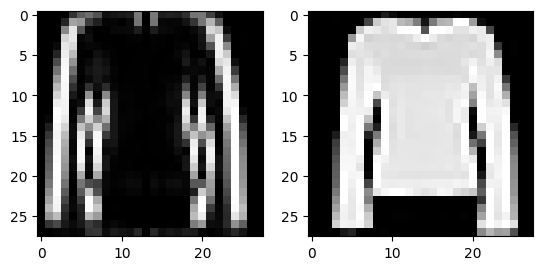

In [81]:
result = complex_n * filter_fft
reconstructed =torch.fft.fft2(result)
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap="gray")

### Horizontal Filter

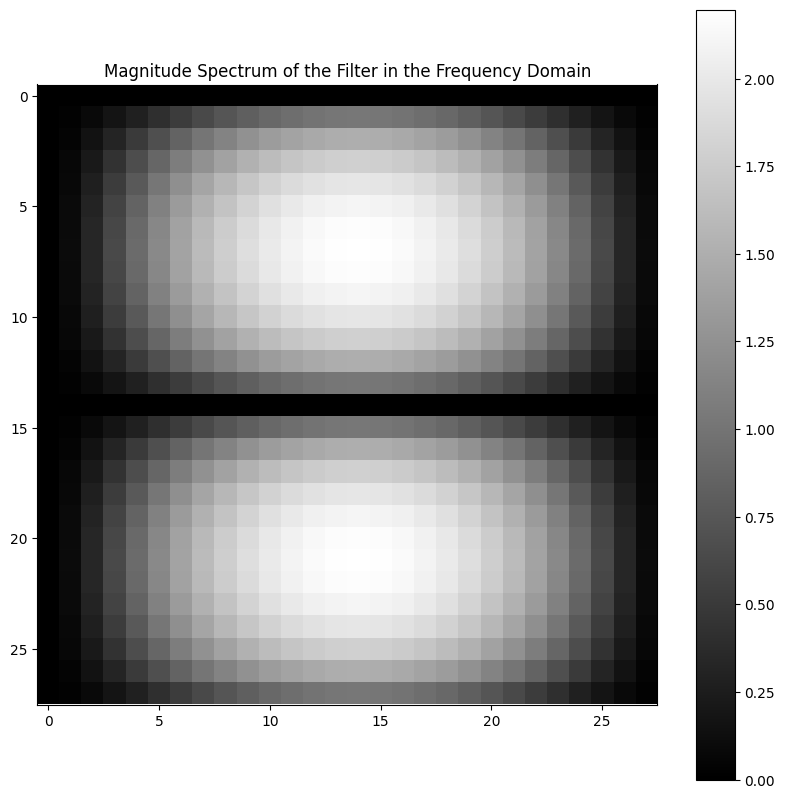

In [82]:
sobel_horizontal = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
])


# Pad the filter to match the image size (256x256)
filter_padded = np.zeros((28, 28))
filter_padded[:3, :3] = sobel_horizontal

# Compute the Fourier transform of the padded filter
filter_fft = np.fft.fft2(filter_padded)

# Shift the zero-frequency component to the center of the spectrum
filter_fft_shifted = np.fft.fftshift(filter_fft)

# Get the magnitude spectrum for visualization
magnitude_spectrum = np.log(np.abs(filter_fft_shifted) + 1)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the Filter in the Frequency Domain')
plt.colorbar()
plt.show()

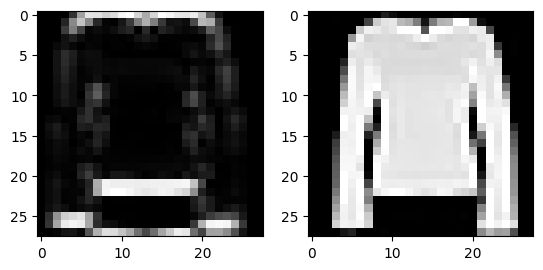

In [84]:
result = complex_n * filter_fft
reconstructed =torch.fft.fft2(result)
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap="gray")

## Larger Filter Kernel

In [85]:
sobel_horizontal_7x7 = np.array([
    [ 1,  2,  3,  4,  3,  2,  1],
    [ 1,  2,  3,  4,  3,  2,  1],
    [ 1,  2,  3,  4,  3,  2,  1],
    [ 0,  0,  0,  0,  0,  0,  0],
    [-1, -2, -3, -4, -3, -2, -1],
    [-1, -2, -3, -4, -3, -2, -1],
    [-1, -2, -3, -4, -3, -2, -1]
])

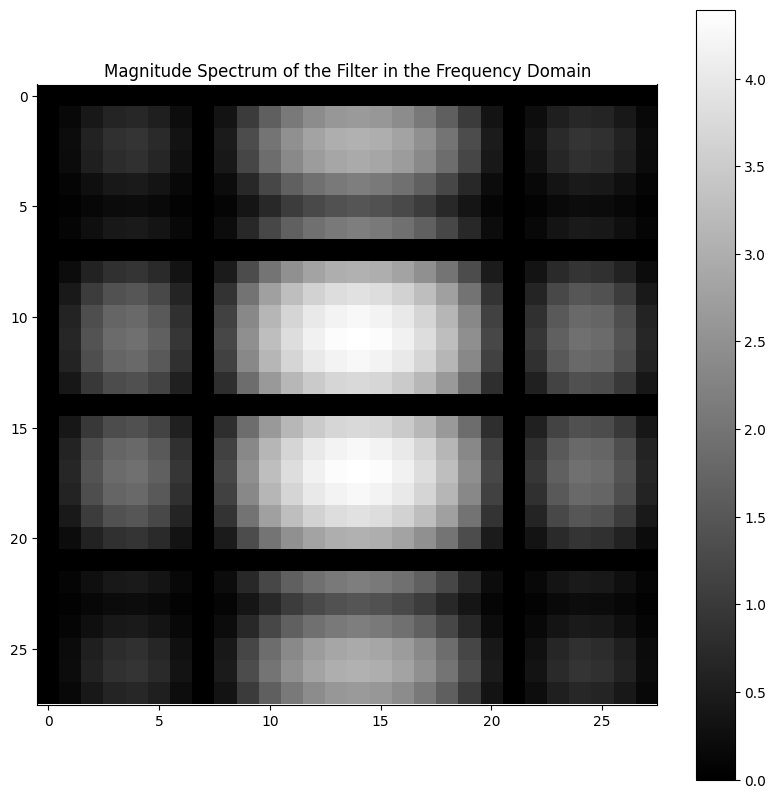

In [87]:
# Pad the filter to match the image size (256x256)
filter_padded = np.zeros((28, 28))
filter_padded[:7, :7] = sobel_horizontal_7x7

# Compute the Fourier transform of the padded filter
filter_fft = np.fft.fft2(filter_padded)

# Shift the zero-frequency component to the center of the spectrum
filter_fft_shifted = np.fft.fftshift(filter_fft)

# Get the magnitude spectrum for visualization
magnitude_spectrum = np.log(np.abs(filter_fft_shifted) + 1)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the Filter in the Frequency Domain')
plt.colorbar()
plt.show()

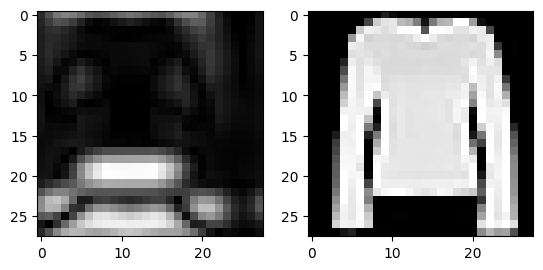

In [88]:
result = complex_n * filter_fft
reconstructed =torch.fft.fft2(result)
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap="gray")

In [89]:
sobel_vertical_7x7 = np.array([
    [-1, -1, -1,  0,  1,  1,  1],
    [-2, -2, -2,  0,  2,  2,  2],
    [-3, -3, -3,  0,  3,  3,  3],
    [-4, -4, -4,  0,  4,  4,  4],
    [-3, -3, -3,  0,  3,  3,  3],
    [-2, -2, -2,  0,  2,  2,  2],
    [-1, -1, -1,  0,  1,  1,  1]
])

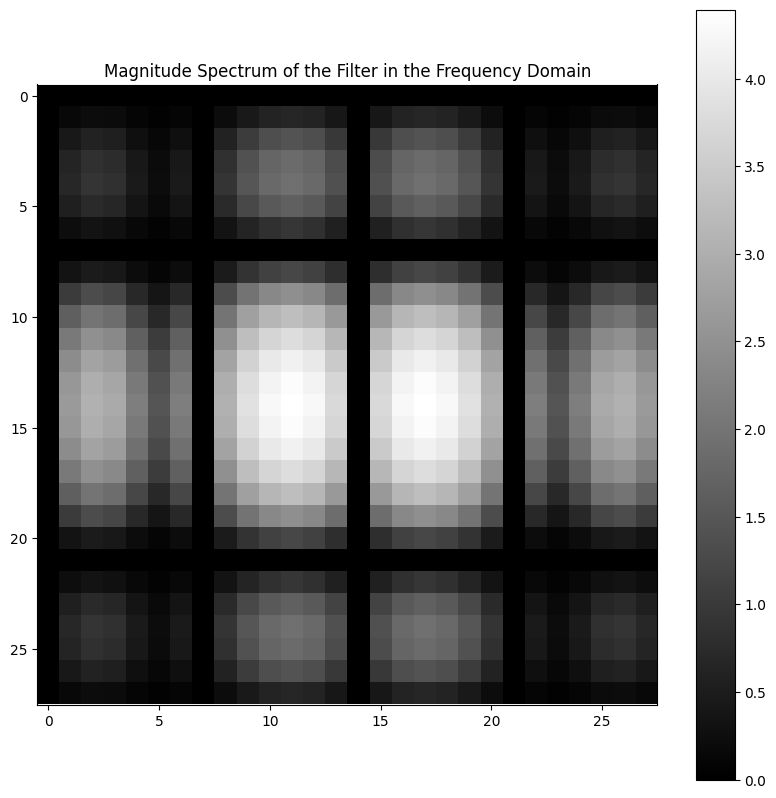

In [93]:
# Pad the filter to match the image size (256x256)
filter_padded = np.zeros((28, 28))
filter_padded[:7, :7] = sobel_vertical_7x7

# Compute the Fourier transform of the padded filter
filter_fft = np.fft.fft2(filter_padded)

# Shift the zero-frequency component to the center of the spectrum
filter_fft_shifted = np.fft.fftshift(filter_fft)

# Get the magnitude spectrum for visualization
magnitude_spectrum = np.log(np.abs(filter_fft_shifted) + 1)
angle_spectrum = np.angle(filter_fft_shifted)
# Plot the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the Filter in the Frequency Domain')
plt.colorbar()
plt.show()

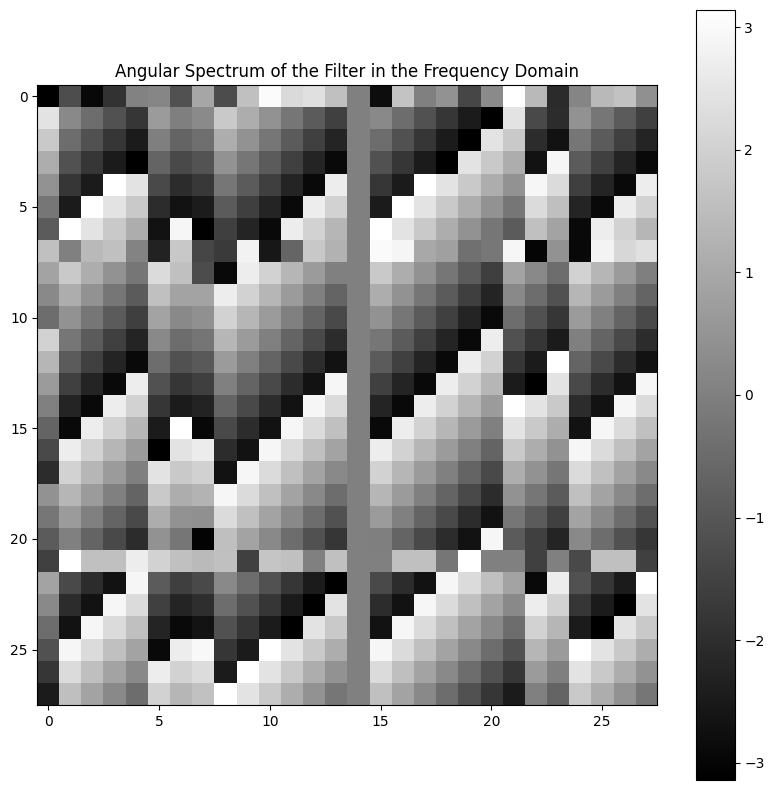

In [95]:

# Plot the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.imshow(angle_spectrum, cmap='gray')
plt.title('Angular Spectrum of the Filter in the Frequency Domain')
plt.colorbar()
plt.show()

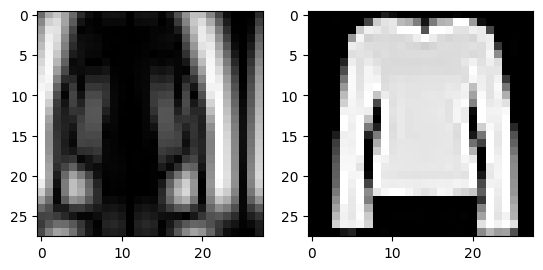

In [91]:
result = complex_n * filter_fft
reconstructed =torch.fft.fft2(result)
plt.subplot(1,2,1)
plt.imshow(np.abs(reconstructed), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.abs(reconstructed_image_fft), cmap="gray")